In [49]:
from collections import Counter
import re

import matplotlib.pyplot as plt

import torch


In [84]:
data = torch.load('../../data/generated/data_train.pt')['data'] + torch.load('../../data/generated/data_test.pt')['data']
x = torch.cat([ d['x'] for d in data ], dim=0)
y = torch.cat([ d['y'] for d in data ])  # is_budding
bud_ids = torch.cat([ d['bud_id'] for d in data ])
time_ids = torch.cat([ d['time_id'] for d in data ])
candidate_ids = torch.cat([ d['candidate_id'] for d in data ])
colony_ids = torch.cat([ torch.tensor([int(re.findall('(?:.*colony)(\d\d\d)(?:_.*)', str(d['fp_segmentation']))[0])] * len(d['y'])) for d in data ])

In [85]:
# compute indices where a new graph starts
# in the data, budding events with nearest neighbours are adjacent
# so we find ranges of consecutive bud_id and time_id

idn_graphs = [0]

for idn in range(1, len(x)):
	if not (bud_ids[idn-1] == bud_ids[idn] and time_ids[idn-1] == time_ids[idn]):
		idn_graphs.append(idn)

idn_graphs.append(len(x))  # delimiter of the last graph

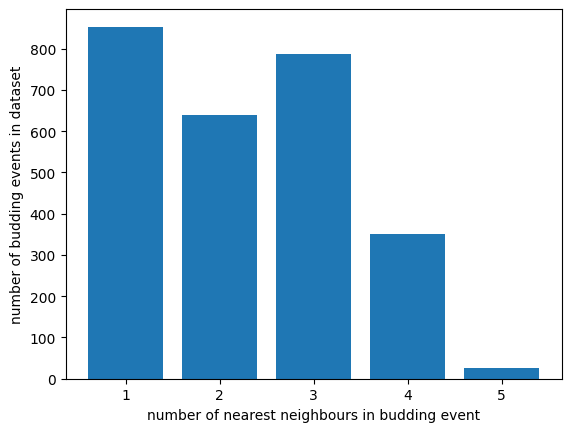

In [86]:
# check graph distribution
cnt = Counter([b-a for b, a in zip(idn_graphs[1:], idn_graphs[:-1])])

fig, ax = plt.subplots()
ax.bar(cnt.keys(), cnt.values())
ax.set_xticks(list(cnt.keys()))
ax.set_xlabel('number of nearest neighbours in budding event')
ax.set_ylabel('number of budding events in dataset')
plt.show()

In [87]:
from torch_geometric.data import Data

In [89]:
datas = []

for i, idn_graph in enumerate(idn_graphs[:-1]):
	data = Data(
		# first row of x is the bud features, rest are parent features
		x=torch.vstack([x[idn_graph, 0:6]] + [x[j, 6:12] for j in range(idn_graphs[i], idn_graphs[i+1])]),  # [bud] + [parents]
		edge_attr=torch.vstack([x[j, 12:25] for j in range(idn_graphs[i], idn_graphs[i+1])]),
		y=torch.vstack([y[j] for j in range(idn_graphs[i], idn_graphs[i+1])]),
		edge_index=torch.vstack([torch.tensor([0, j+1]) for j in range(idn_graphs[i+1]-idn_graphs[i])]).type(torch.long)
	)
	if not data.y.any():
		# strange cases where the true parent is not in the nearest neighbours !
		print(data)
		print(f'bud_id={bud_ids[idn_graph]}, nn_ids={[int(candidate_ids[j]) for j in range(idn_graphs[i], idn_graphs[i+1])]}, time_id={time_ids[idn_graph]}, colony_id={colony_ids[idn_graph]}')
	datas.append(data)

Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=148, colony_id=4
Data(x=[5, 6], edge_index=[4, 2], edge_attr=[4, 13], y=[4, 1])
bud_id=53, nn_ids=[7, 9, 12, 35], time_id=141, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=55, nn_ids=[4, 22, 25], time_id=141, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=148, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=149, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=150, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=151, colony_id=4
Data(x=[4, 6], edge_index=[3, 2], edge_attr=[3, 13], y=[3, 1])
bud_id=66, nn_ids=[4, 8, 62], time_id=152, colony_id=4
Data(x=[5, 6], edge_index=[4, 2], edge_attr=[4, 13]